In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import numpy as np
import os

In [ ]:
train_dir = os.path.join('/content/drive/MyDrive/Train')
validation_dir = os.path.join('/content/drive/MyDrive/Validation')
train_defective_dir = os.path.join('/content/drive/MyDrive/Train/Defective')
train_nondefective_dir = os.path.join('/content/drive/MyDrive/Train/Non defective')
validation_defective_dir = os.path.join('/content/drive/MyDrive/Validation/Defective')
validation_nondefective_dir = os.path.join('/content/drive/MyDrive/Validation/Non defective')

In [ ]:
train_defective_fnames = os.listdir(train_defective_dir )
train_nondefective_fnames = os.listdir( train_nondefective_dir)

print(train_defective_fnames[:20])
print(train_nondefective_fnames[:20])

In [ ]:
print('total training defective images :', len(os.listdir(train_defective_dir)))
print('total training non-defective images :', len(os.listdir(train_nondefective_dir)))
print('total validation defective images :', len(os.listdir( validation_defective_dir ) ))
print('total validation non-defective images :', len(os.listdir( validation_nondefective_dir) ))

In [ ]:
# Parameters for our graph; we'll output images in a 10x10 configuration
nrows = 4
ncols = 4
# Index for iterating over images
pic_index = 0

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

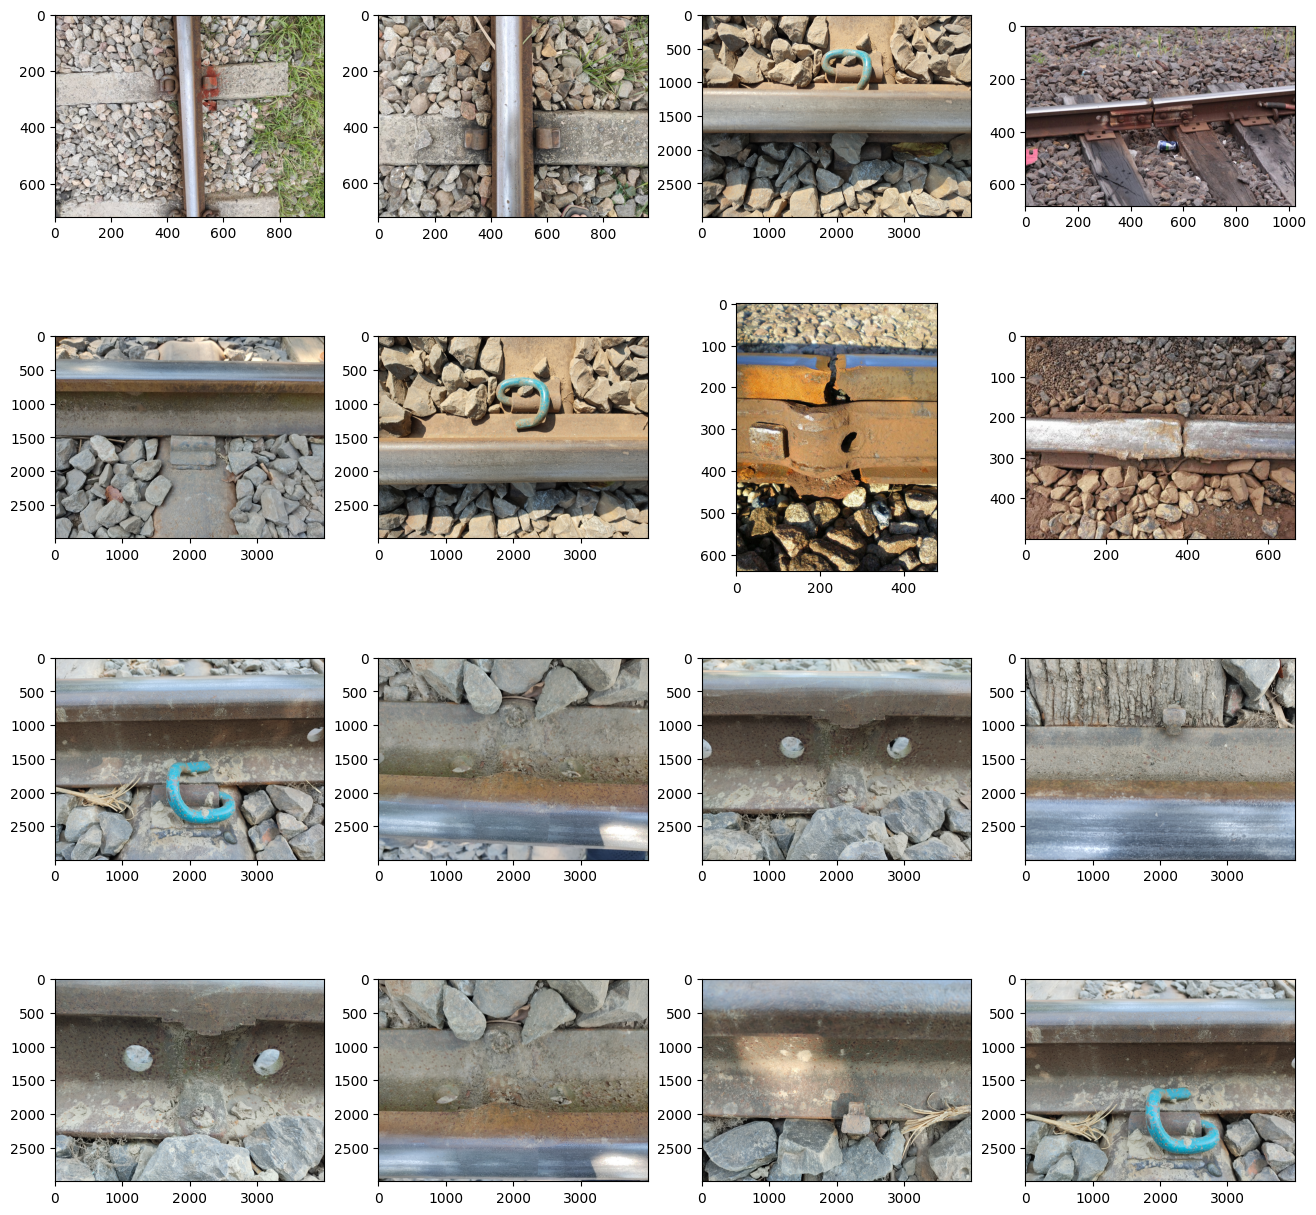

In [ ]:
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_defective_pix = [os.path.join(train_defective_dir, fname)
                for fname in train_defective_fnames[pic_index-8:pic_index]]
next_nondefective_pix = [os.path.join(train_nondefective_dir, fname)
                for fname in train_nondefective_fnames[pic_index-8:pic_index]]


for i, img_path in enumerate(next_defective_pix+next_nondefective_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
import cv2
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
local_weights_file = '/content/drive/MyDrive/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'


pre_trained_model = InceptionV3(input_shape = (300,300, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False
pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output.shape)
last_output = last_layer.output

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#DATA PREPROCESSING

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

In [ ]:
# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(300,300))
# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (300,300))

In [ ]:
# from tensorflow.keras.optimizers import RMSprop

# # Flatten the output layer to 1 dimension
# x = layers.Flatten()(last_output)
# # Add a fully connected layer with 1,024 hidden units and ReLU activation
# x = layers.Dense(32, activation='relu')(x)
# # Add a dropout rate of 0.2
# x = layers.Dropout(0.2)(x)
# # Add a final sigmoid layer for classification
# x = layers.Dense(1, activation='sigmoid')(x)

# model = Model( pre_trained_model.input, x)

# model.compile(optimizer = 'Adam',
#               loss = 'binary_crossentropy',
#               metrics = ['accuracy'])
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained InceptionV3 model (excluding top layer)
base_model = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(300, 300, 3)
)

# Freeze all layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Build custom top layers
x = base_model.output
x = GlobalAveragePooling2D()(x)          # Global average pooling instead of Flatten
x = Dense(128, activation='relu')(x)     # Increased capacity
x = Dropout(0.5)(x)                       # Higher dropout to reduce overfitting
x = Dense(32, activation='relu')(x)      # Additional Dense layer
x = Dropout(0.2)(x)                       # Optional second dropout
predictions = Dense(1, activation='sigmoid')(x)  # Binary classification output

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(
    optimizer=Adam(learning_rate=0.0001),       # Lower LR helps with transfer learning
    loss='binary_crossentropy',
    metrics=['accuracy']
)


In [ ]:
model.summary()

In [ ]:
history = model.fit(train_generator,
                              validation_data=validation_generator,
                              epochs=25,
                              verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 208s 13s/step - accuracy: 0.4743 - loss: 0.7447 - val_accuracy: 0.7258 - val_loss: 0.6362
Epoch 2/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 144s 10s/step - accuracy: 0.5238 - loss: 0.7381 - val_accuracy: 0.6935 - val_loss: 0.6210
Epoch 3/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.6004 - loss: 0.6737 - val_accuracy: 0.7581 - val_loss: 0.5858
Epoch 4/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 144s 9s/step - accuracy: 0.5991 - loss: 0.6702 - val_accuracy: 0.7258 - val_loss: 0.6008
Epoch 5/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 157s 10s/step - accuracy: 0.6489 - loss: 0.6253 - val_accuracy: 0.8226 - val_loss: 0.6011
Epoch 6/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.6571 - loss: 0.6457 - val_accuracy: 0.7903 - val_loss: 0.5541
Epoch 7/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 158s 10s/step - accuracy: 0.6271 - loss: 0.6594 - val_accuracy: 0.6935 - val_loss: 0.5877
Epoch 8/25
15/15 ━━━━━━━━━━━━━━━━━━━━ 141s 9s/step - accuracy: 0.6997 - loss: 0.5958 - val_accuracy: 0.7581

In [ ]:
model_save_name=model.save('mymodel.h5',history)
print('model save successfully')

model save successfully


Text(0.5, 1.0, 'Training and validation loss')

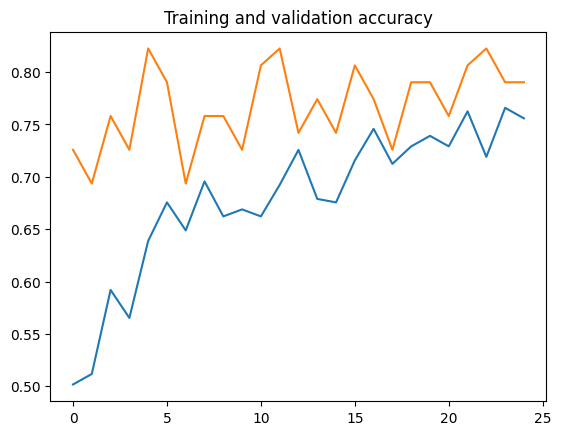

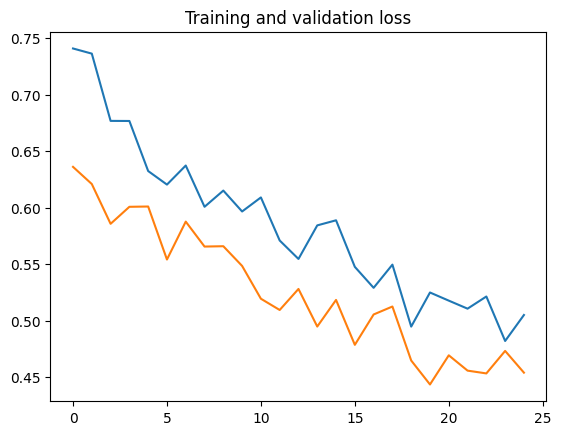

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'  )

In [ ]:
# Predict on the validation set
Y_pred = model.predict(validation_generator)
y_pred = (Y_pred > 0.5).astype(int).flatten()  # Convert probabilities to binary

4/4 ━━━━━━━━━━━━━━━━━━━━ 31s 6s/step


In [ ]:
y_true = validation_generator.classes

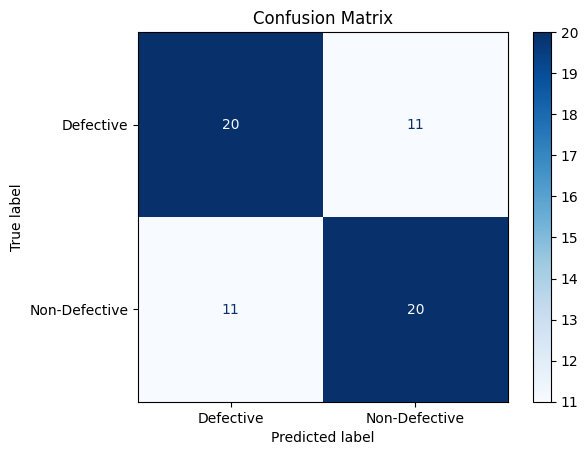

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Defective', 'Non-Defective'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Get true labels
y_true = validation_generator.classes

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

# Optional: Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

Validation Accuracy: 64.52%

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65        31
           1       0.65      0.65      0.65        31

    accuracy                           0.65        62
   macro avg       0.65      0.65      0.65        62
weighted avg       0.65      0.65      0.65        62

Confusion Matrix:
[[20 11]
 [11 20]]


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[[3.8195152e-20]]
This Railway track has fault


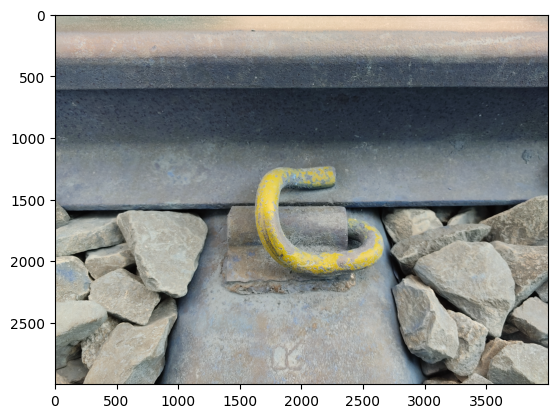

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
img = cv2.imread('/content/drive/MyDrive/Test/Non defective/IMG_20201114_100023.jpg')
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step
[[1.074271e-18]]
This Railway track has fault


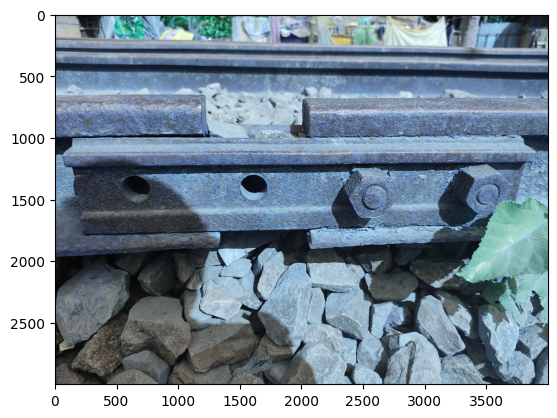

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Test/Defective/IMG_20201114_102222.jpg')
plt.imshow(img)
img = cv2.resize(img,(300,300))
img = np.reshape(img,[1,300,300,3])

classes = model.predict(img)

print(classes)
if classes>0.5:
    print("This Railway track has no fault")
else:
    print("This Railway track has fault")